# Simulation using Tweedie's formula for bias correction

Here's a cut out of the overleaf text to give context for the simulation:

> We start with the given relationship $Y = \hat{Y} - \epsilon_1$ where $\epsilon_1 \perp \hat{Y}$. Here, we add an assumption that $\epsilon_1$ is gaussian, i.e. $\epsilon_1 \sim \mathcal{N}(0, \sigma_1^2)$. This implies $Y \mid \hat{Y} \sim \mathcal{N}(\hat{Y}, \sigma_1^2)$.
> 
> According to Tweedie's formula, the posterior mean can be expressed as
> 
> \begin{equation}
>     \mathbb{E}[\hat{Y} \mid Y] = Y + \sigma_1^2 \frac{d}{dY} \log p_Y(Y)
> \end{equation}
> 
> where $p_Y(Y)$ is the marginal density of $Y$.
> 
> Interpretation: The expected predicted value $\hat{Y}$ for a given $Y$ will be close to $Y$, but slightly shifted in the direction where $Y$ is denser. That is, for a $Y$ in the tail, the predicted value will be closer to the center. This is what leads us to overestimate the wealth in poor regions and underestimate the wealth in rich regions. 

> ### Next step: Use this when estimating $\tau$
> 
> If we have
> 
> \begin{equation}
>     \tau = \mathbb{E}\left[ Y \mid A=1 \right] - \mathbb{E}\left[ Y \mid A=0 \right]
> \end{equation}
> 
> then (I believe) we should have
> 
> \begin{align}
>     \mathbb{E}\left[\hat{\tau} \mid \tau \right] &= \mathbb{E}\left[ \mathbb{E}[\hat{Y} \mid Y] \mid A=1 \right] - \mathbb{E}\left[ \mathbb{E}[\hat{Y} \mid Y] \mid A=0 \right] \\
>     &= \mathbb{E}\left[ Y + \sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=1 \right] - \mathbb{E}\left[ Y + \sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=0 \right] \\
>     &= \underbrace{\mathbb{E}\left[ Y \mid A=1 \right] - \mathbb{E}\left[ Y \mid A=0 \right]}_{\tau} + \mathbb{E}\left[ \sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=1 \right] - \mathbb{E}\left[\sigma_1^2 \frac{d}{dY} \log p_Y(Y) \mid A=0 \right] \\
>     &= \tau + \sigma_1^2 \left( \mathbb{E}\left[ \frac{d}{dY} \log p_Y(Y) \mid A=1 \right] - \mathbb{E}\left[\frac{d}{dY} \log p_Y(Y) \mid A=0 \right] \right)
> \end{align}

Let's see if this works! We start out by defining the marginal density $P_{\hat{Y}}(Y)$.

In [2]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

class MarginalYHat:
    def __init__(self, strata_weights, strata_c_means, strata_c_std_devs, strata_t_means, strata_t_std_devs, t_ratio):

        self.strata_weights = strata_weights
        self.strata_c_means = strata_c_means
        self.strata_c_std_devs = strata_c_std_devs
        self.strata_t_means = strata_t_means
        self.strata_t_std_devs = strata_t_std_devs
        self.t_ratio = t_ratio

    def pdf(self, y_hat, treatment_status='all'):
        pdf_value = 0

        if treatment_status == 't':
            for i in range(len(self.strata_weights)):
                pdf_value += self.strata_weights[i] * norm.pdf(y_hat, loc=self.strata_t_means[i], scale=self.strata_t_std_devs[i])
        elif treatment_status == 'c':
            for i in range(len(self.strata_weights)):
                pdf_value += self.strata_weights[i] * norm.pdf(y_hat, loc=self.strata_c_means[i], scale=self.strata_c_std_devs[i])
        else:
            for i in range(len(self.strata_weights)):
                pdf_value += self.strata_weights[i] * (self.t_ratio * norm.pdf(y_hat, loc=self.strata_t_means[i], scale=self.strata_t_std_devs[i]) + (1 - self.t_ratio) * norm.pdf(y_hat, loc=self.strata_c_means[i], scale=self.strata_c_std_devs[i]))
        return pdf_value
        
    def sample(self, num_samples, treatment_status='all', return_treatment_status=False):

        component_choices = np.random.choice(len(self.strata_weights), size=num_samples, p=self.strata_weights)
        if treatment_status == 't':
            t_status = np.ones(num_samples, dtype=bool)
            samples = np.array([np.random.normal(self.strata_t_means[i], self.strata_t_std_devs[i]) for i in component_choices])
        elif treatment_status == 'c':
            t_status = np.zeros(num_samples, dtype=bool)
            samples = np.array([np.random.normal(self.strata_c_means[i], self.strata_c_std_devs[i]) for i in component_choices])
        else:
            t_status = np.random.choice([True, False], size=num_samples, p=[self.t_ratio, 1 - self.t_ratio])
            samples = np.array([np.random.normal(self.strata_t_means[i], self.strata_t_std_devs[i]) if t_status[j] else np.random.normal(self.strata_c_means[i], self.strata_c_std_devs[i]) for j, i in enumerate(component_choices)])

        if return_treatment_status:
            return samples, t_status
        else:
            return samples

Let's define our distribution for $\hat{Y}$. In theory, it should work for any distribution, but I define it as a mixture of Gaussians. The first "strata" will represent rural points. I say that 80% of points belong to this strata and that they (prior to treatment) have a mean wealth of 5 and a spread of 1. The remaining 20% belong to the urban strata and have both a higher mean and a higher spread, 13 and 4, respectively. This roughly reminds me of my memory of what the DHS distribution looks like. For each strate, I then take 20% of the points and increase them by a value $\tau_{\hat{Y}}$, simulating a treatment. This give me a mixture of Gaussian on the following form:

$$
P_{\hat{Y}}(y) = \underbrace{0.8 \cdot \left( 0.8 \cdot \mathcal{N}(y; 5, 1^2) + 0.2 \cdot \mathcal{N}(y; 5 + \tau_{\hat{Y}}, 1^2) \right)}_{\text{Rural}} + \underbrace{0.2 \cdot \left( 0.8 \cdot \mathcal{N}(y; 13, 4^2) + 0.2 \cdot \mathcal{N}(y; 13 + \tau_{\hat{Y}}, 4^2) \right)}_{\text{Urban}}
$$

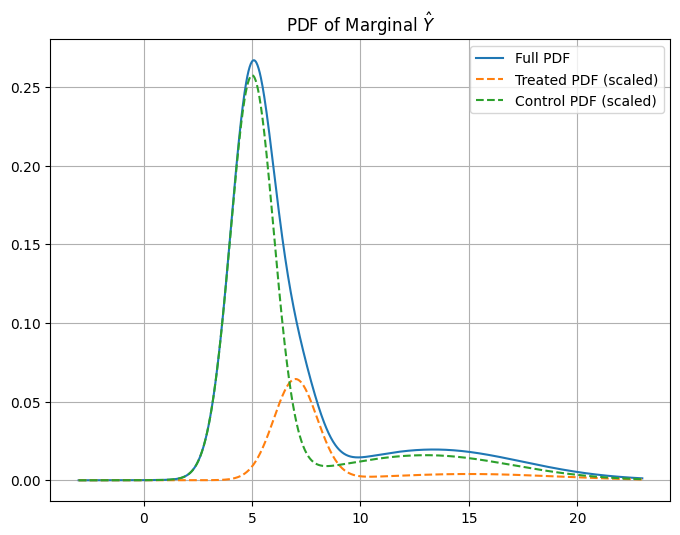

In [3]:
# Define the parameters for the mixture of Gaussians
tau_hat = 2.0
strata_weights = np.asarray([0.8, 0.20])  # Weights for each stratum
strata_c_means = np.asarray([5, 13])  # Means for each stratum in the control group
strata_c_std_devs = np.asarray([1, 4])  # Standard deviations for each stratum in the control group
strata_t_means = strata_c_means + tau_hat  # Means for each stratum in the treated group
strata_t_std_devs = strata_c_std_devs  # Standard deviations for each stratum in the treated group
t_ratio = 0.2  # Proportion of treated

# Create the marginal Y_hat object
marginal_Y_hat = MarginalYHat(strata_weights, strata_c_means, strata_c_std_devs, strata_t_means, strata_t_std_devs, t_ratio)

# Plot the PDFs
y_hat_values = np.linspace(-3, 23, 1000)
pdf_values_t = t_ratio * np.array([marginal_Y_hat.pdf(y_hat, treatment_status='t') for y_hat in y_hat_values])
pdf_values_c = (1 - t_ratio) * np.array([marginal_Y_hat.pdf(y_hat, treatment_status='c') for y_hat in y_hat_values])
pdf_values_all = np.array([marginal_Y_hat.pdf(y_hat, treatment_status='all') for y_hat in y_hat_values])

plt.figure(figsize=(8, 6))
plt.plot(y_hat_values, pdf_values_all, label='Full PDF')
plt.plot(y_hat_values, pdf_values_t, '--', label='Treated PDF (scaled)')
plt.plot(y_hat_values, pdf_values_c, '--', label='Control PDF (scaled)')
plt.title('PDF of Marginal $\hat{Y}$')
plt.legend()
plt.grid(True)
plt.show()

Verify that the sampling works by drawing some samples and plotting the histogram

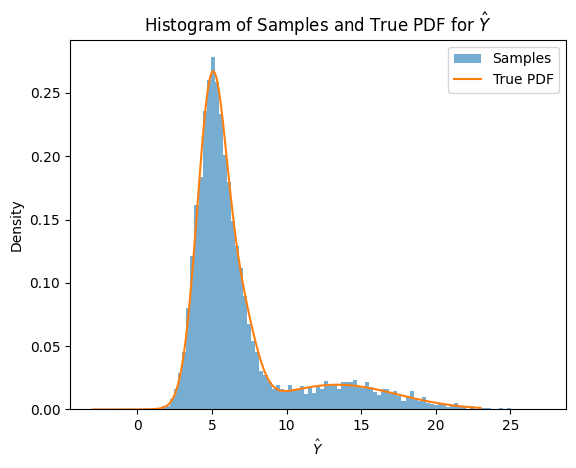

In [4]:
# Sample from the marginal Y_hat distribution
num_samples = 10000
y_hat_samples, t_status = marginal_Y_hat.sample(num_samples, return_treatment_status=True)

# Plot the histogram of the samples with the true PDF
plt.hist(y_hat_samples, bins=100, density=True, alpha=0.6, label='Samples')
plt.plot(y_hat_values, pdf_values_all, label='True PDF')
plt.xlabel('$\hat{Y}$')
plt.ylabel('Density')
plt.title('Histogram of Samples and True PDF for $\hat{Y}$')
plt.legend()
plt.show()

We need to also get an expression for $Y$ since we assumed above that $Y = \hat{Y} + \mathcal{N}(0, \sigma^2)$ we create such a class.

In [4]:
class MarginalY:
    def __init__(self, marginal_y_hat, sigma_y):
        self.marginal_y_hat = marginal_y_hat
        self.sigma_y = sigma_y
    
    def pdf(self, y):
        pdf_value = 0

        for i in range(len(self.marginal_y_hat.strata_weights)):

            # Control group
            strata_c_var = self.marginal_y_hat.strata_c_std_devs[i]**2 + self.sigma_y**2
            pdf_value += self.marginal_y_hat.strata_weights[i] * (1 - self.marginal_y_hat.t_ratio) * norm.pdf(y, loc=self.marginal_y_hat.strata_c_means[i], scale=np.sqrt(strata_c_var))

            # Treated group
            strata_t_var = self.marginal_y_hat.strata_t_std_devs[i]**2 + self.sigma_y**2
            pdf_value += self.marginal_y_hat.strata_weights[i] * self.marginal_y_hat.t_ratio * norm.pdf(y, loc=self.marginal_y_hat.strata_t_means[i], scale=np.sqrt(strata_t_var))

        return pdf_value
    
    def sample(self, num_samples):
        y_hat_samples = self.mixture_model.sample(num_samples)
        y_samples = y_hat_samples + np.random.normal(0, self.sigma_y, num_samples)
        return y_samples

    def conditional_sample(self, y_hat_samples):
        y_samples = y_hat_samples + np.random.normal(0, self.sigma_y, len(y_hat_samples))
        return y_samples
    
    def score(self, y):
        pdf_value = self.pdf(y)  # Compute p_Y(Y)
        if pdf_value == 0:
            return 0  # Avoid division by zero
        
        score_value = 0
        for i in range(len(self.marginal_y_hat.strata_weights)):
            strata_c_var = self.marginal_y_hat.strata_c_std_devs[i]**2 + self.sigma_y**2
            strata_t_var = self.marginal_y_hat.strata_t_std_devs[i]**2 + self.sigma_y**2

            c_pdf = norm.pdf(y, loc=self.marginal_y_hat.strata_c_means[i], scale=np.sqrt(strata_c_var))
            t_pdf = norm.pdf(y, loc=self.marginal_y_hat.strata_t_means[i], scale=np.sqrt(strata_t_var))

            c_term = -((y - self.marginal_y_hat.strata_c_means[i]) / strata_c_var) * c_pdf
            t_term = -((y - self.marginal_y_hat.strata_t_means[i]) / strata_t_var) * t_pdf

            score_value += self.marginal_y_hat.strata_weights[i] * ((1 - self.marginal_y_hat.t_ratio) * c_term + self.marginal_y_hat.t_ratio * t_term)

        return score_value / pdf_value  # Compute d/dY log p_Y(Y)


Let's plot the marginal distributions for $Y$ and $\hat{Y}$

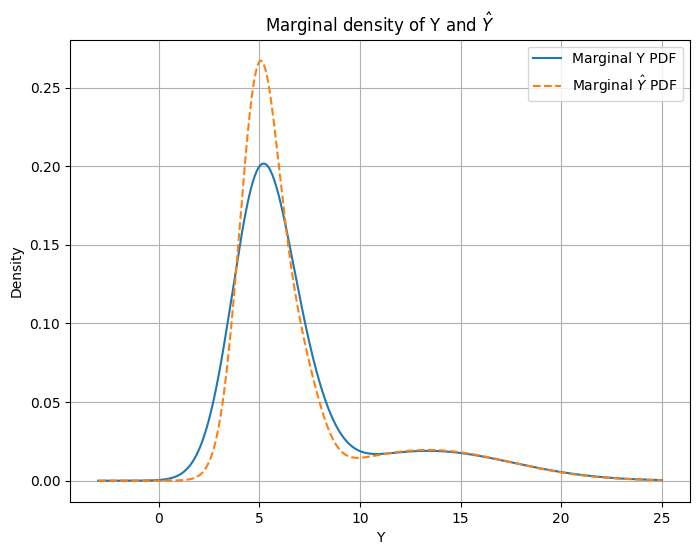

In [16]:
# Define the parameters for the marginal Y distribution
sigma_y = 1.0

# Create the marginal Y object
marginal_Y = MarginalY(marginal_Y_hat, sigma_y)

# Plot the PDFs
y_values = np.linspace(-3, 25, 1000)
y_pdf_values = np.array([marginal_Y.pdf(y) for y in y_values])
y_hat_pdf_values = np.array([marginal_Y_hat.pdf(y_hat, treatment_status='all') for y_hat in y_values])

plt.figure(figsize=(8, 6))
plt.plot(y_values, y_pdf_values, label='Marginal Y PDF')
plt.plot(y_values, y_hat_pdf_values, '--', label='Marginal $\hat{Y}$ PDF')
plt.xlabel('Y')
plt.ylabel('Density')
plt.title('Marginal density of Y and $\hat{Y}$')
plt.legend()
plt.grid(True)
plt.show()

We see that $\hat{Y}$ roughly follows the shape of $Y$, but with the densities more concentrated around the modes. This gives a smaller variance, which is in line with our expectations.

Now, let's also plot the score function for $Y$

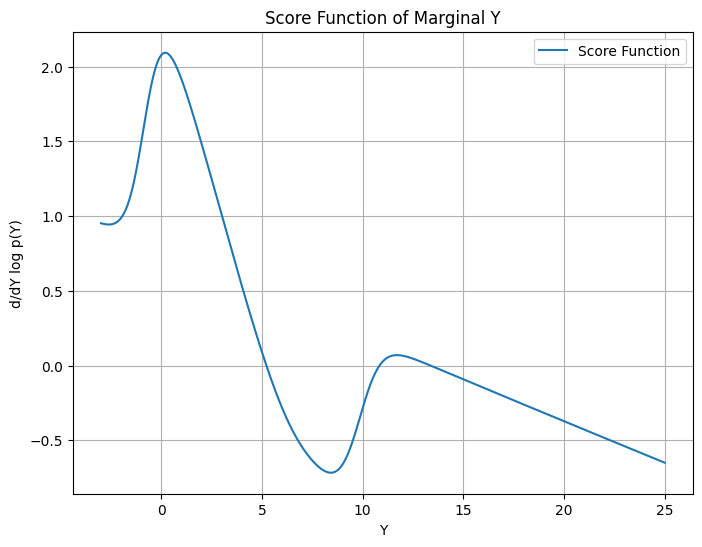

In [17]:
# Plot the score function
y_score_values = np.array([marginal_Y.score(y) for y in y_values])

plt.figure(figsize=(8, 6))
plt.plot(y_values, y_score_values, label='Score Function')
plt.xlabel('Y')
plt.ylabel('d/dY log p(Y)')
plt.title('Score Function of Marginal Y')
plt.legend()
plt.grid(True)
plt.show()

This looks reasonable, with $\frac{d}{dY} \log p(Y)$ following what we expect from the curve in the previous plot (e.g. is 0 at the local max- and minima, positive on the left and negative on the right)

Let's estimate the effect using $\hat{Y}$ ($\hat{\tau}$) and $Y$ ($\tau$) respectively. We assume that $\hat{\tau}$ will end up being 2.0 (as this is how we defined `tau_hat`). We expect $\tau$ to be something else, as this represents the "true" treatment effect, not biased by the noisy labels.

In [ ]:
# Sample from the marginal Y_hat distribution
num_samples = 1000000
y_hat_samples, t_status = marginal_Y_hat.sample(num_samples, return_treatment_status=True)

# Sample from the marginal Y distribution
y_samples = marginal_Y.conditional_sample(y_hat_samples)

# Calculate the ATE from the samples
hat_ate_estimate = np.mean(y_hat_samples[t_status]) - np.mean(y_hat_samples[~t_status])
ate_estimate = np.mean(y_samples[t_status]) - np.mean(y_samples[~t_status])
print(f'Estimated hat ATE: {hat_ate_estimate} (True hat ATE: {tau_hat})')
print(f'True sample ATE: {ate_estimate}')

Estimated hat ATE: 1.9911190379005275 (True hat ATE: 2.0)
True sample ATE: 1.9859161401806844


**Problem**: They both ended up being the same. Why is this? Well, it is not very surprising as, here, $Y \mid A$ is just $\hat{Y} \mid A$ plus some Gaussian noise. Is this realistic? I don't think so... Feels like we shouldn't make the modes like this already for $P_{\hat{Y}}(Y)$. How can I set up a proper simulation?

### Some more plots

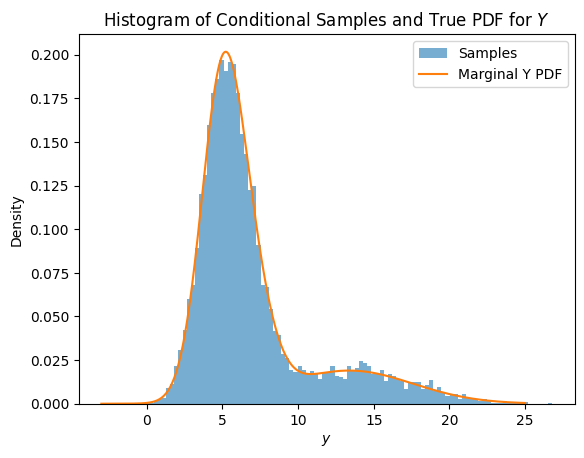

In [19]:
# Sample from the marginal Y_hat distribution
num_samples = 10000
y_hat_samples, t_status = marginal_Y_hat.sample(num_samples, return_treatment_status=True)

# Sample from the marginal Y distribution
y_samples = marginal_Y.conditional_sample(y_hat_samples)

# Plot the histogram of the samples with the true PDF
plt.hist(y_samples, bins=100, density=True, alpha=0.6, label='Samples')
plt.plot(y_values, y_pdf_values, label='Marginal Y PDF')
plt.xlabel('$y$')
plt.ylabel('Density')
plt.title('Histogram of Conditional Samples and True PDF for $Y$')
plt.legend()
plt.show()

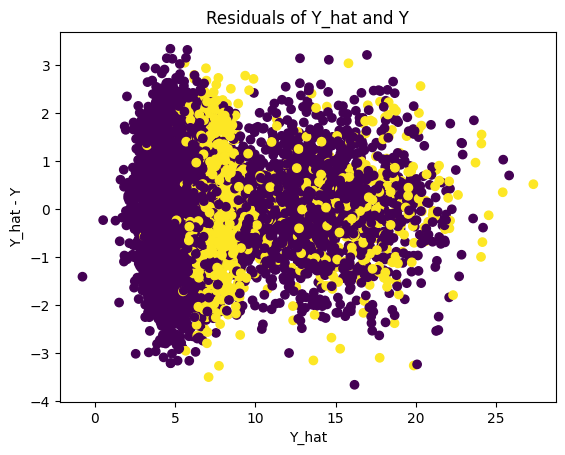

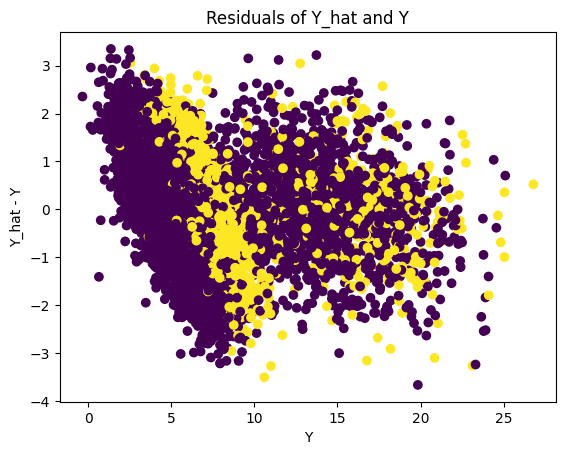

In [20]:
plt.scatter(y_hat_samples, y_hat_samples-y_samples, c=t_status)
plt.xlabel('Y_hat')
plt.ylabel('Y_hat - Y')
plt.title('Residuals of Y_hat and Y')
plt.show()

plt.scatter(y_samples, y_hat_samples-y_samples, c=t_status)
plt.xlabel('Y')
plt.ylabel('Y_hat - Y')
plt.title('Residuals of Y_hat and Y')
plt.show()